# Prepare ETD Light Curves for analysis in AIJ #

This code has been written hastily in order to prepare the light curves downloaded from [Exoplanet Transit Database (ETD)](http://var2.astro.cz/ETD/) to be analyzed in [AstroImageJ (AIJ)](https://www.astro.louisville.edu/software/astroimagej/) by converting the column that keeps time to BJD-TDB format, computing the AIRMASS based on the location of the observers and the coordinates of the object and printing an output file that will be used in the analysis with AIJ.

Since ETD light curves have been acquired by amateur observers, they ignore airmass-detrending, which improves the precision of mid-transit times measured from those light curves. So I have written a small code-piece in Python (hosted in this Jupyter notebook) to convert the light curves in ETD to BJD-TDB time scale, compute the airmass, which you can find below.

You can either run each cell one by one (by pressing `Ctrl+Enter` at the same time or from the Kernel menu, by clicking the option `Restart & Run All` once for all. The cells with code in it have `In` prefix (short for Input), there are also cells for formatted text (like this one, called markdown cells) to explain how the code works and provide directions for what to do next. For more information on [Jupyter notebooks](https://jupyter.org/), you can have a look at the tutorial from the [Data Camp](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook) or use the Notebook Help and Use Interface Tour options in the `Help` menu. I strongly suggest using Keyboard Shortcuts which are listed from the Help menu as well.

In [1]:
# First import the needed packages
from astropy import time, coordinates as coord, units as u
import pandas as pd
import numpy as np
import os
from IPython.display import display, FileLink
from ipywidgets import FileUpload
import ipython_blocking

### Prepare and upload the light curve data ###

Most observers in ETD upload their light curve in a well-defined format. Nevertheless it is not trivial to determine which separator they use and how they name their columns. Most importantly, they can add information on the parameters of the photometry (aperture sizes, number of stars etc.) to first, second or sometimes the last line of their files. Some observers skip column header names and just dump the light curve data to their light curve files. Although these inconvenience can be properly handled and avoided in the code, unfortunately, I don't have time to fix these issues. So I kindly ask you to prepare your light curve file before you upload it.

<div style="background-color: palevioletred; color: white; padding: 10px;">
Please open the light curve file in your local copy and delete all the unnecessary lines, that are the lines without column headers or data, whereever they appear and save them. If there is no line for the column header at the beginning of your files, please add one with column names relevant to the and delimit them with the same separator the observer use to delimit his/her data.
</div>

In [16]:
# Let the user upload the data first
upload = FileUpload(accept='.dat', 
    multiple=False)  # We want to convert once at a time
display(upload)
%block upload

FileUpload(value={}, accept='.dat', description='Upload')

In [3]:
uploaded_file = upload.value
filename = list(uploaded_file.keys())[0]
with open("./lc.txt", "wb") as fp:
    fp.write(uploaded_file[filename]["content"])

### Read the light curve file ###

The code then reads the file. However ETD observers, unfortunately, separate the columns in their data files using different delimiters such as `space`, `<TAB>`, `,` etc. So we need to know the delimiter and ask the user to enter it. You can see the content of your file from this [link](./lc.txt).

In [4]:
# We need to know the separator used in the file to 
separator = input("Please enter the delimiter used to separate the columns in your file. Enter 't' if your file is tab delimited, 's' if space delimited without single quotes: \n")

Please enter the delimiter used to separate the columns in your file. Enter 't' if your file is tab delimited, 's' if space delimited without single quotes: 
s


In [5]:
if separator == 't':
    separator = '\t'
elif separator == 's':
    separator = ' '
lc = pd.read_csv("lc.txt", sep=separator, skipinitialspace=True)
print("Your light curve is: ")
print(lc.head())
# Now that we are done with the original light curve file
# We can delete it from the server
os.remove("lc.txt")

Your light curve is: 
             JD      V-C       s1
0  2.458700e+06  0.07613  0.00061
1  2.458700e+06  0.07306  0.00061
2  2.458700e+06  0.07205  0.00064
3  2.458700e+06  0.07146  0.00069
4  2.458700e+06  0.07291  0.00075


### Column names with important information ###

We need to know which column keeps the time information, which one keeps the flux (or magnitude) and which one keeps its error. These are the only required columns. So provide (exactly) the name of each column when asked.

In [6]:
# Ask which column is which
jdcol = input("Which column keeps your time in JD?\n")
flux = input("Which column keeps your flux (or magnitude)?\n")
fluxerr = input("Which column keeps your flux (or magnitude) errors? If it is not in your file then hit <enter>\n")

Which column keeps your time in JD?
JD
Which column keeps your flux (or magnitude)?
V-C
Which column keeps your flux (or magnitude) errors? If it is not in your file then hit <enter>
s1


### Plot the light curve ###

If everything went well, when you run the cell below your light curve should display. If your light curve is upside down, this means that the brightness is in magnitude units. You don't have to do anything but only tick the relevant box (`Input in mag`) in AIJ (y-axis menu) to indicate that your light curve is in magnitudes.

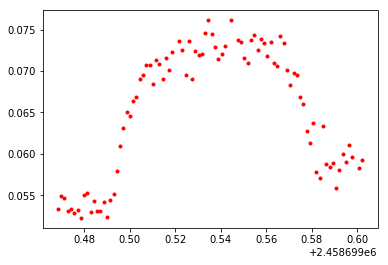

In [7]:
# Plot the light curve
# and remind the user if the light curve is upside down
# that it is in magnitudes
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(lc[jdcol],lc[flux],'r.')
plt.show()

### Time format and scale ###

For every time frame, there is a format (YYYY-MM-DD, 245xxxx.xxxxx, etc.) and a scale (UTC, TAI, TDB, etc.). The default scale in ETD is UTC. So we only the reference time frame. Whether it is JD (geocentric), HJD (heliocentric) or BJD (barycentric). We then use this information to convert the times to barycentric dynamic scale (TDB) in BJDs (BJD-TDB). This information is either given in the header of your light curve file (the first line) or in the window when you click TRESCA link in ETD, just below the transit profiles where the mid-transit times and their errors are listed.

In [8]:
# Which reference frames are your timings in (JD, HJD or BJD) in UTC
jdtype = input("What is the reference frame for the timings reported in UTC scale Please enter 'JD' for geocentric, 'HJD' for heliocentric, 'BJD' for barycentric values?: \n")

What is the reference frame for the timings reported in UTC scale Please enter 'JD' for geocentric, 'HJD' for heliocentric, 'BJD' for barycentric values?: 
JD


### Outlier Removal ###

For the moment there is a very simple outlier removal code piece below, which will be changed with an algorithm based on standard deviations of moving medians in the future. But you can always remove the outliers in the AIJ too.

In [9]:
# Remove outliers
# Discarding criteria is 5*sigma
mu = lc[flux].mean()
sigma = lc[flux].std()
llim = mu - 5*sigma
ulim = mu + 5*sigma
# index of the points out of the limits
index2drop = lc[(lc[flux] > ulim) | (lc[flux] < llim)].index
lc.drop(index2drop , inplace=True)

### No error column! ###

There will be data files without a column filled with errors on the brightness values. If no such column exists, then the code computes the standard deviation of flux (or mag) for the first and last 5 data points and assigns the number to all data points as their error bars. This is only for convenience, EXOFAST weighs all data points the same since the errors are the same and the mid-transit time error is calculated from the goodness of fit statistics of the model. So the magnitude of that error bar has no effect when it is the same for all data points.

In [10]:
# if error column is empty, calculate standard deviation of
# first 5 and last 5 points and use it for all as a fudge factor
# exofast already weighs these equally
if fluxerr == '':
    series4std = pd.concat([lc[flux][:5],lc[flux][-6:]])
    fluxstd = series4std.std()
    fluxerr = flux + '_err'
    lc[fluxerr] = fluxstd*np.ones(len(lc[flux]))

### Coordinates of the host star: ###

If your object is not found in the Simbad, and the code is not able to bring its coordinates (highly unlikely), then it asks for your help. Then please enter the RA and DEC of your star (in J2000 epoch from Simbad database) in the required format (hh mm ss.s for RA and dd mm ss.s, you can copy the entire line for this information in J2000 epoch in the Simbad query result and paste here).

In [11]:
# Let's try to find the star's coordinates in Simbad
# Get the name of the light curve file from the user
hoststar = input("Please enter the name of the host star as is given in Simbad: \n")
try:
    star_coords = coord.SkyCoord.from_name(hoststar)
except:
    RA = input("Please enter the right ascension of your star in hh mm ss.s format: \n")
    DEC = input("Please enter the declination of your star in dd mm ss.s format: \n")
    star_coords = coord.SkyCoord(RA, DEC, frame='icrs',\
                        unit=(u.hourangle,u.deg), equinox="J2000")

Please enter the name of the host star as is given in Simbad: 
HAT-P-23


### Location of the Observer ###

For BJD-TDB and AIRMASS calculation, the code needs to know where the observation has been made. You can provide this information either by entering the name of the database (unfortunately most amateur observatories reporting their data to ETD are not in the list) or entering the address of the observatory, which you can copy from the window opens when you click on the TRESCA link (it then looks for the address in Google Earth) or simply by providing the geographical latitude and longitude in degrees. This information is also provided in the TRESCA link below the name of the observatory. The precision (only integers) is sufficient for our purpose. 

In [12]:
# Now let us determine the location of the observer
print("The observatories in our database are \n")
print(coord.EarthLocation.get_site_names())
observatory = input("Please enter the name of the observatory. If your observatory is not in the list hit <enter>\n")

if observatory == '':
    observatory_address = input("Try entering the address of the observatory look for its coordinates in Google Earth: \n")
    if observatory_address == '':
        obslong = float(input("Please enter the longitude of the observatory in d.ddd format (east is positive): \n"))
        obslat = float(input("Please enter the latitude of the observatory in dd.dddd format (north is positive): \n"))
        obsalt = float(input("Please enter the altitude of the observatory in meters (if not known enter 0): \n"))
        obsloc = coord.EarthLocation(lat=obslat*u.deg, lon=obslong*u.deg, height=obsalt*u.m)
    else: 
        try:
            obsloc = coord.EarthLocation.of_site(observatory_address)
        except:
            print("The address you have entered can not be found in Google Earth!")
            obslong = float(input("Please enter the longitude of the observatory in d.ddd format (east is positive): \n"))
            obslat = float(input("Please enter the latitude of the observatory in dd.dddd format (north is positive): \n"))
            obsalt = float(input("Please enter the altitude of the observatory in meters (if not known enter 0): \n"))
            obsloc = coord.EarthLocation(lat=obslat*u.deg, lon=obslong*u.deg, height=obsalt*u.m)
else:
    obsloc = coord.EarthLocation.of_site(observatory)


The observatories in our database are 

['', '', '', 'ALMA', 'ATST', 'Anglo-Australian Observatory', 'Apache Point', 'Apache Point Observatory', 'Atacama Large Millimeter Array', 'BAO', 'BBSO', 'Beijing XingLong Observatory', 'Black Moshannon Observatory', 'CHARA', 'Canada-France-Hawaii Telescope', 'Catalina Observatory', 'Cerro Pachon', 'Cerro Paranal', 'Cerro Tololo', 'Cerro Tololo Interamerican Observatory', 'DCT', 'DKIST', 'Discovery Channel Telescope', 'Dominion Astrophysical Observatory', 'GBT', 'Gemini South', 'Green Bank Telescope', 'Hale Telescope', 'Haleakala Observatories', 'Happy Jack', 'IAO', 'JCMT', 'James Clerk Maxwell Telescope', 'Jansky Very Large Array', 'Keck Observatory', 'Kitt Peak', 'Kitt Peak National Observatory', 'La Silla Observatory', 'Large Binocular Telescope', 'Las Campanas Observatory', 'Lick Observatory', 'Lowell Observatory', 'MWA', 'Manastash Ridge Observatory', 'McDonald Observatory', 'Medicina', 'Medicina Dish', 'Michigan-Dartmouth-MIT Observatory', 

### Conversion to BJD-TDB ###

Then the code converts the timings to BJD-TDB by adding the time it takes for the light to travel from the Earth (geocentric JD case) to the barycenter or from the center of the Sun to the barycenter (heliocentric HJD case). If the timings are reported in BJD, onl the scale is converted to TDB from the UTC.

In [13]:
# Let's convert the timings to BJD-TDB
times = time.Time(lc[jdcol], format='jd',scale='utc', location=obsloc)
# Cacluate bbarycentric or heliocentric time difference
# converts UTC to BJD and add ltt diffrence
if jdtype == "JD":
    ltt_bary = times.light_travel_time(star_coords)
elif jdtype == 'HJD':
    ltt_helio = times.light_travel_time(star_coords, 'heliocentric')
    times -= ltt_helio
    ltt_bary =  times.light_travel_time(star_coords)
elif jdtype == 'BJD':
    ltt_bary = 0.
else:
    print("Your timing frame is not recognized")
    os.exit()
time_barycentre = times.tdb + ltt_bary
bjd_tdb = time_barycentre.value
times_bjd_tdb = time.Time(bjd_tdb, format='jd', scale='tdb')
lc['BJD-TDB'] = times_bjd_tdb

### Airmass Computation ###

Then the airmass is computed from the altitude-azimuth coordinates of the object with the formula given by Hardie (1962), which is valid for all zenith angles smaller than 85 degress.

In [14]:
# Calculate the altitude / azimuth coordinates for the object 
altaz = star_coords.transform_to(coord.AltAz(obstime=times_bjd_tdb, location=obsloc))
# and zenith angle
secz = 1 / np.cos(altaz.zen)
# to determine the airmass from Hardie (1962)
X = secz - 0.0018167*(secz - 1) - 0.002875*(secz - 1)**2 - 0.0008083*(secz -1)**3
lc['airmass'] = X

### Write the new light curve file ###

Now the output file is written in four columns (BJD-TDB, flux or mag, its error, and airmass) to an output file with the same file root ending with the suffix <i>_converted.dat</i> in the relevant (for your host star) data folder.

In [15]:
# dump the data in pandas dataframe lc to a new file
# First find the index of the last '.' character where the extension starts
indext = len(filename) - filename[-1::-1].find('.') - 1
file2wr = filename[:indext]+'_converted.dat'
try:
    # sort the values
    lc.to_csv(file2wr, sep = '\t', \
          float_format = '%.6f', \
          columns=['BJD-TDB', flux, fluxerr, 'airmass'],\
          index=True)
    local_file = FileLink(file2wr, result_html_prefix="Click here to download: ")
    display(local_file)
    print("Your file is ready to download")
except:
    print("""There is an expected error in writing your file.
Please make sure you have run all the code cells
and they have not thrown error messages. Then
please check if you have permission to write
in the folder you try to save your file""")

/media/Windows/Dropbox/science/papers/current/ttv_ephemeris_paper/HAT-P-23_101_converted.dat

Your file is ready to download


### Good luck! ###

The code has no error-handling unfortunately. So <b><u>you are at your own risk</u></b>. You have to enter the information correctly. Otherwise it crashes! If an unexpected error occur please let us know and we will correct the code if the error is some bug or direct you otherwise.

Once your file is ready, please open this file with AIJ. By your eye (or by computing if you know how to do it), try to find the ingress and egress points. Enter them in the main window upper right (Right and Left Limits) copy them to the boxes down below in the same window to normalization limits. And then in the y-axis menu (long menu) where you control what is plotted; please tick the box if the unit of the flux is magnitude in the input file. Then it is converted to flux by AIJ. Then in the same menu fit the sections of the light curve before the ingress and after the egress (green boxes on each side of a white box) and enter the name of the airmass column (airmass) to the trend drop-down menu to its right. And then normalize the light curve in the same way. Then you should click on the left most button next to the first row in this menu, which is a disc symbol to provide the flux_dn, and fluxer_dn (these are detrended and normalized flux values and their errors you produced but may have different names based on the names of the columns in the original data file). You don't have to add BJD_dn column because we have it already! 

Then from the main window, save the entire light curve with all the plot configurations as mostly you do from "save with options" option. When asks the columns for the datasubset file please enter BJD-TDB, flux, fluxerr, airmass, flux_dn, fluxerr_dn. And that's it. save all the output files somewhere.  

Good luck!